In [1]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install wordcloud matplotlib

  Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pillow-11.2.1-cp312-cp312-win_amd64.whl.metadata (9.1 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl (301 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pillow-11.2.1-cp312-cp312-win_


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input, Dense, Embedding, Dot, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,TensorBoard

from wordcloud import WordCloud
%matplotlib inline

#### Reading data

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [5]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv") , low_memory=True,usecols=["user_id","anime_id","rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
rating_df.describe()

,user_id,anime_id,rating
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.339305e+03,1.657369e+04,4.306854e+00
std,4.742759e+03,1.379504e+04,3.906990e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.291000e+03,3.297000e+03,0.000000e+00
50%,8.378000e+03,1.254900e+04,6.000000e+00
75%,1.242100e+04,3.091100e+04,8.000000e+00
max,1.650800e+04,4.849100e+04,1.000000e+01


#### Data Processing

In [62]:
n_user = rating_df['user_id'].value_counts()

In [63]:
n_user

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
11167      400
11932      400
4125       400
4529       400
5375       400
Name: count, Length: 4203, dtype: int64

In [64]:
rating_df = rating_df[rating_df["user_id"].isin(n_user[n_user>=400].index)].copy()

In [14]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [15]:
len(rating_df)

3246641

In [19]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [20]:
avg_rating

np.float64(4.122732695114736)

In [21]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating))

In [25]:
np.mean(rating_df['rating'])

np.float64(0.4122732695114729)

In [26]:
rating_df.duplicated().sum()

np.int64(0)

In [27]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [28]:
user_ids = rating_df['user_id'].unique().tolist()

In [32]:
user2user_encoding = {x : i for i,x in enumerate(user_ids)}
user2user_decoding = {i : x for i,x in enumerate(user_ids)}

rating_df["user"] = rating_df['user_id'].map(user2user_encoding)

In [69]:
n_user = len(user_ids)

In [34]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [35]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoding = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoding = {i : x for i,x in enumerate(anime_ids)}

rating_df["anime"] = rating_df['anime_id'].map(anime2anime_encoding)

In [36]:
n_anime = len(anime2anime_encoding)

In [37]:
n_anime

17149

In [38]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [42]:
X = rating_df[['user','anime']]
y = rating_df["rating"]

In [45]:
test_size = 1000

In [46]:
train_indices = rating_df.shape[0] - test_size

In [53]:
X_train , X_test , y_train , y_test = X[:train_indices].values , X[train_indices:].values ,y[:train_indices].values , y[train_indices:].values 

In [54]:
len(X_train) , len(X_test)

(3245641, 1000)

In [60]:
X_train_array = [X_train[ : , 0],X_train[ :, 1]]
X_test_array = [X_test[ : , 0],X_test[ : , 1]]

In [61]:
type(X_test_array) , type(X_test_array[0])

(list, numpy.ndarray)

### Model Architecture

In [76]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user",shape=[1])
    user_embedding = Embedding(name= "user_embeddings",input_dim=n_user,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name= "anime_embeddings",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name = "Dot_product" , normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user,anime],outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='Adam',metrics = ['mae','mse'])

    return model

In [77]:
n_anime

17149

In [78]:
model = RecommenderNet()

In [79]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embeddings     │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embeddings    │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embeddings[… │
│                     │                   │            │ anime_embeddings… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ Dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [80]:
start_learning_rate = 0.0001
min_learning_rate = 0.0001
max_learning_rate = 0.00005
batch_size = 10000

ramup_epoch = 5
sustain_epoch = 0
exp_decay = 0.8

def lrfn(epoch):

    if epoch<ramup_epoch:
        return(max_learning_rate-start_learning_rate)/ramup_epoch*epoch+start_learning_rate
    
    elif epoch<ramup_epoch+sustain_epoch:
        return max_learning_rate
    
    else:
        return (max_learning_rate-min_learning_rate)*exp_decay **(epoch-ramup_epoch-sustain_epoch) + min_learning_rate

In [81]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_weight = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_weight,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode = 'min',
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor = "val_loss",
                               mode = 'min',
                               restore_best_weights =True)

In [82]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [83]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=20,
    batch_size=batch_size,
    verbose = 1,
    validation_data=(X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.7798 - mae: 0.3785 - mse: 0.1906 - val_loss: 0.6940 - val_mae: 0.3612 - val_mse: 0.1573 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7483 - mae: 0.3655 - mse: 0.1775 - val_loss: 0.7188 - val_mae: 0.3595 - val_mse: 0.1673 - learning_rate: 9.0000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7085 - mae: 0.3469 - mse: 0.1603 - val_loss: 0.6900 - val_mae: 0.3391 - val_mse: 0.1536 - learning_rate: 8.0000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.6553 - mae: 0.3187 - mse: 0.1369 - val_loss: 0.6437 - val_mae: 0.3121 - val_mse: 0.1329 - learning_rate: 7.0000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.6153 - mae: 0.2950 - mse: 0.1189 - val_loss: 0.6169 - val_mae: 0.2960 - val_mse: 0.1208 - learning_rate: 6.0000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.5939 - mae: 0.2816 - mse: 0.1094 - val_los

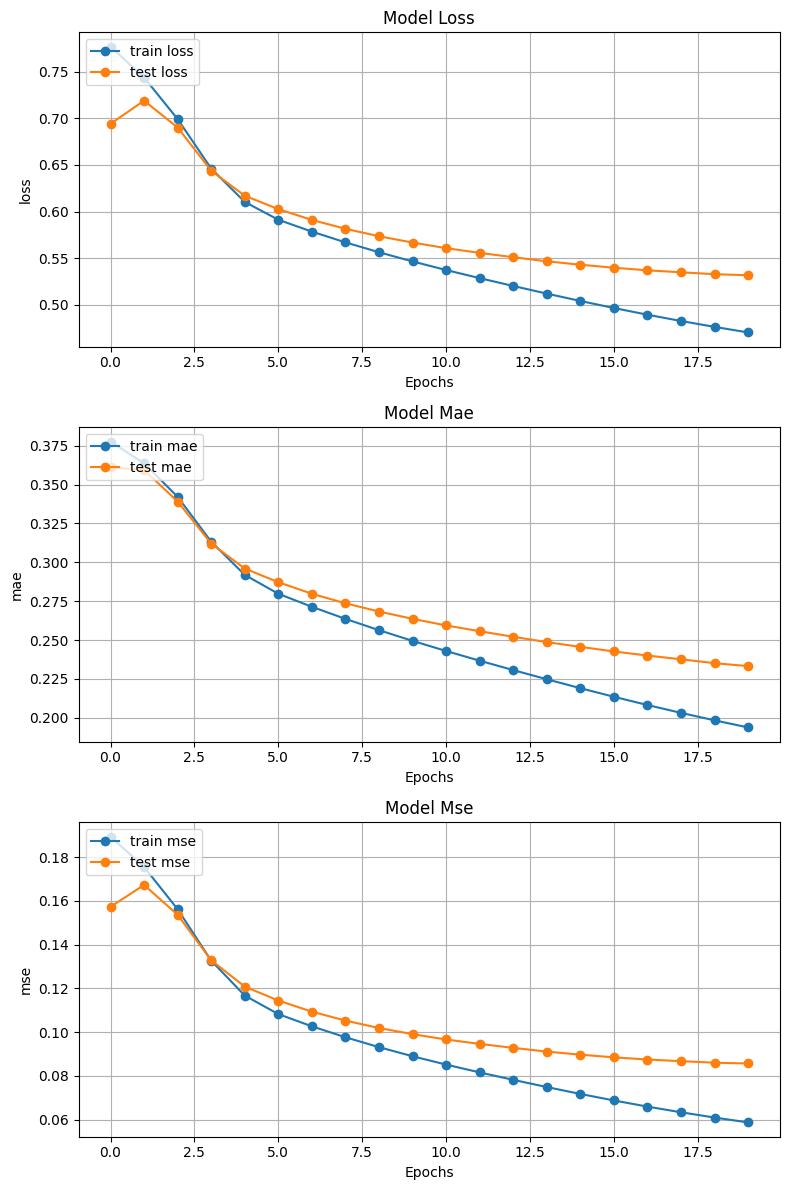

In [86]:
metrics = ["loss","mae","mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric],marker = "o",label = f"train {metric}")
    ax.plot(history.history[f"val_{metric}"],marker = "o",label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    ax.legend(loc = "upper left")
    ax.grid(True)
plt.tight_layout()
plt.show()

In [90]:
def extract_weights(name,model):
    weights_layer = model.get_layer(name)
    weights = weights_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights


In [91]:
anime_weights = extract_weights("anime_embeddings",model)

In [92]:
user_weights = extract_weights("user_embeddings",model)

#### Reading Anime.csv

In [93]:
df = pd.read_csv(INPUT_DIR+"/anime.csv" ,low_memory=True)

In [94]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [95]:
df = df.replace("Unknown",np.nan)

In [98]:
def get_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
        return name
    except:
        print("Error")

In [101]:
df['anime_id'] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:get_anime_name(x))

In [103]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,english_version,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster,Beet the Vandel Buster


In [107]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,english_version,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop,Cowboy Bebop


In [108]:
get_anime_name(67)

'Basilisk'

In [109]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

In [110]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,english_version,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4,Gintama Season 4


In [111]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'english_version', 'eng_version'],
      dtype='object')

In [113]:
df = df [["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [114]:
df.columns

Index(['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type',
       'Premiered', 'Members'],
      dtype='object')

In [115]:
def get_anime_frame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [119]:
get_anime_frame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### Anime_with_synopsis.csv

In [124]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [125]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv" ,usecols=cols)

In [205]:
(synopsis_df.MAL_ID == 3793).sum()

np.int64(0)

In [214]:
def get_synopsis(anime,df):
    if isinstance(anime,int):
        return df[df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return df[df.Name == anime].sypnopsis.values[0]

#### Content Based Recommendation System

In [135]:
pd.set_option("max_colwidth",None)

In [138]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [216]:
def find_similar_animes(name,
                        anime_weights,
                        anime2anime_encoding,
                        anime2anime_decoding,
                        df,
                        synopsis_df,
                        n=10,
                        return_dist = False,
                        neg=False):
    try:
        index = get_anime_frame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoding.get(index)
        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n=n+1

        if neg :
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists , closest
        
        similarity_array = []
        for close in closest:

            decoded_id = anime2anime_decoding.get(close)

            print(decoded_id)
            synopsis = get_synopsis(decoded_id,synopsis_df)

            anime_frame = get_anime_frame(decoded_id,df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.values[0]
            similarity = dists[close]

            similarity_array.append(
                {
                    "anime_id" :decoded_id,
                    "name": anime_name,
                    "genre": genre,
                    "similarity": similarity,
                    "synopsis" : synopsis
                }
            )
        
        frame = pd.DataFrame(similarity_array).sort_values(by ="similarity" ,ascending=False)
        return frame[frame.anime_id!=index].drop(["anime_id"],axis=1)
    except Exception as e: 
        print("Error",e)

In [219]:
find_similar_animes(
    "Doraemon the Movie:Nobita and the Birth of Japan 2016",
    anime_weights,
    anime2anime_encoding,
    anime2anime_decoding,
    df,
    synopsis_df
)

Anime closest to Doraemon the Movie:Nobita and the Birth of Japan 2016
539
1185
6634
8424
2092
1181
1398
22547
314
36716
31201


,name,genre,similarity,synopsis
9,Boku wa Mada 7-sai Datta,"[36716, Boku wa Mada 7-sai Datta, 6.26, Music, 1, Music, nan, 240]",0.405324,usic video for the band Lukas Graham's song 7 Years in their second studio album.
8,Ace wo Nerae! 2,"[314, Ace wo Nerae! 2, 6.87, Drama, Shoujo, Sports, 13, OVA, nan, 2001]",0.392271,Three years has passed since the events of the first series. Hiromi continued training with her coach and became Japan's junior champion. Their common profits have also contributed to the coach being chosen as the first trainer of the Japanese Selection of Tennis and is arranged to head a trip with the youngest members of the team to USA. The relation between Hiromi and its trainer is narrower at personal level but it exceeds the teacher-student bond with great difficulty. (Source: AniDB)
7,Blade & Soul,"[22547, Blade & Soul, 6.09, Action, Adventure, Fantasy, Martial Arts, 13, TV, Spring 2014, 109933]",0.389150,"lka is an assassin for the Clan of the Sword. She's on a journey to find the woman Jin Valel, who killed her master Hon without feeling—not unlike how Alka has learned to kill in her work as an assassin. On her journey, Alka encounters three strange women, each a great warrior in her own right and grapples with her slain master's wish that she leaves the life of an assassin behind. (Source: ANN)"
6,Macross Dynamite 7,"[1398, Macross Dynamite 7, 6.84, Sci-Fi, Adventure, Space, Comedy, Mecha, Shounen, 4, OVA, nan, 11086]",0.386829,"ss than a year after the events that transpired in the Macross 7 TV series, Basara leaves Fire Bomber and travels to the planet Zola. There, he meets a girl named Elma, who is a big fan of Fire Bomber. It is also on this planet where he must once again use his Spiritia powers; this time, to stop an army of poachers and Elma's father Graham from killing a group of space whales travelling within the planetary system."
5,Ruin Explorers Fam & Ihrie,"[1181, Ruin Explorers Fam & Ihrie, 6.66, Action, Adventure, Comedy, Fantasy, Magic, 4, OVA, nan, 6664]",0.386696,"Fam and Ihrie are willing to do almost anything to make a buck. So when these debt-driven damsels discover the potential profits to be hand in recovering a particularly dangerous mystical object, it means mortal peril for an entire civilization. There's no guarantee that they'll live long enough to squander the fabulous wealth they've been promised, and danger lurks around every turn as they cross dark seas in pursuit of legendary evil. Haunted by an unspeakable curse, plagued by doomsday prophecies, plotted against by untrustworthy traveling companions and looked in desperate race to gain the Ultimate Power, Fam and Ihrie are the Ruin Explorers! (Source: AniDB)"
4,Kiss wa Hitomi ni Shite,"[2092, Kiss wa Hitomi ni Shite, 5.89, Drama, Romance, Shoujo, 1, OVA, nan, 976]",0.384622,"High school student Morisato Ibuki has a startling dream about kissing a prince on a white horse. The next day, the prince from her dream, Ebisu Naoto, shows up as a transfer student at her school and a guest at her house. He had indeed kissed her, in an attempt to wake her up in the morning, although he claims that she kissed him. Ibuki is smitten with Naoto, but he seems to have other commitments, to American football and to a mysterious girl called Kawahara Izumi. Meanwhile, Nitta, a shy boy in Ibuki's class, has a crush on her. Will true love eventually find a way? (Source: Orphan Fansubs)"
3,MM!,"[8424, MM!, 7.12, Harem, Comedy, Ecchi, School, 12, TV, Fall 2010, 204287]",0.382910,"Taro Sado is a high school student who lives his day to day life with a big secret—he's a masochist! Encouraged by his cross-dressing best friend Tatsukichi Hayama, Taro asks the Second Voluntary Club for help with his problem and ends up joining the club after they vow to ""fix"" him. However, it turns out that all of the members of the club have some serious issues. The club leader Mio Isurugi is a self-designated god who is afraid of cats, Arashiko Yuuno has a severe 

In [198]:
anime2anime_decoding.get(3793)

9724

In [200]:
get_synopsis(3793,synopsis_df)

,MAL_ID,Name,Genres,sypnopsis


In [218]:
get_anime_frame("Doraemon the Movie:Nobita and the Birth of Japan 2016",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10860,31201,Doraemon the Movie:Nobita and the Birth of Japan 2016,7.25,"Adventure, Comedy, Fantasy, Kids, Shounen",1,Movie,NaN,2565


In [217]:
df.sample(10)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4528,6267,Eko Eko Azarak,NaN,"Fantasy, Horror, Magic",1,OVA,NaN,503
4487,6165,White Album Season 2,6.84,"Drama, Harem, Music, Romance",13,TV,Fall 2009,40366
5355,8369,Crayon Shin-chan Movie 18: Chou Jikuu! Arashi wo Yobu Ora no Hanayome,7.32,"Sci-Fi, Adventure, Comedy, Seinen",1,Movie,NaN,3456
2265,2470,Space Pirate Captain Harlock:Riddle of the Arcadia Episode,6.96,"Action, Sci-Fi, Adventure, Space, Drama",1,Movie,NaN,4520
12040,33736,After School,NaN,School,NaN,ONA,NaN,1140
7232,15159,Fantastic Children: Befort no Kodomo-tachi no Sonogo,7.01,Slice of Life,1,Special,NaN,1625
13312,35913,Arctic Adventure:On Frozen Pond,NaN,"Adventure, Kids",1,Movie,NaN,122
10860,31201,Doraemon the Movie:Nobita and the Birth of Japan 2016,7.25,"Adventure, Comedy, Fantasy, Kids, Shounen",1,Movie,NaN,2565
9942,29129,Ookami Shoujo to Kuro Ouji Recap,6.82,"Comedy, Romance, School, Shoujo",1,Special,NaN,13252
15253,38963,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.: Menma e no Tegami,7.14,"Comedy, Drama",1,Special,NaN,16604


In [210]:
anime2anime_decoding.get(3793)

9724

In [211]:
anime2anime_encoding.get(9724)

3793

In [212]:
anime2anime_encoding

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [213]:
anime2anime_decoding

{0: 24833,
 1: 235,
 2: 36721,
 3: 40956,
 4: 31933,
 5: 5042,
 6: 7593,
 7: 21,
 8: 35446,
 9: 24,
 10: 22,
 11: 38034,
 12: 17251,
 13: 5762,
 14: 31580,
 15: 33253,
 16: 35028,
 17: 9513,
 18: 368,
 19: 11633,
 20: 31964,
 21: 33486,
 22: 31740,
 23: 1470,
 24: 1575,
 25: 2904,
 26: 1535,
 27: 28223,
 28: 226,
 29: 38671,
 30: 32872,
 31: 15,
 32: 71,
 33: 7661,
 34: 245,
 35: 263,
 36: 5258,
 37: 270,
 38: 24703,
 39: 15451,
 40: 8074,
 41: 11061,
 42: 28961,
 43: 34542,
 44: 14719,
 45: 20899,
 46: 26055,
 47: 34933,
 48: 37086,
 49: 1604,
 50: 22535,
 51: 189,
 52: 34599,
 53: 29575,
 54: 10620,
 55: 32182,
 56: 23755,
 57: 20,
 58: 1735,
 59: 35581,
 60: 5040,
 61: 30276,
 62: 34134,
 63: 6893,
 64: 11499,
 65: 29786,
 66: 16498,
 67: 28171,
 68: 32282,
 69: 9253,
 70: 3455,
 71: 22319,
 72: 10851,
 73: 40658,
 74: 29809,
 75: 25397,
 76: 2852,
 77: 1635,
 78: 1636,
 79: 40337,
 80: 39085,
 81: 857,
 82: 9721,
 83: 36625,
 84: 6987,
 85: 8577,
 86: 9849,
 87: 4010,
 88: 16642,
 